In [4]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2




# Boundary conditions

+ The boundary conditions are the conditions on the solution at the boundary of the domain, whether the domain is space or time
+ The boundary conditions are usually specified as a function of the independent variable(s) (e.g. time or space) on a subset of the domain


# Projecting onto basis functions

+ Instead of meshing space directly, project onto a finite set of basis functions that span the space
+ Basically like meshing in momentum space, if our PDE is in position space
+ The basis functions are usually chosen to be orthogonal, and our resulting dynamical variables are the amplitudes of various "modes"
+ Fourier basis functions are the most common (assumes domain is a torus), but there are many others. Chebyshev polynomials are another common choice for cases where the domain is a finite interval

## The Diffusion Equation

+ A differential equation that is often used to model the diffusion of a quantity through a medium
+ Appears in many contexts, including heat transfer, fluid flow, diffusion of molecules
+ Even the Schrodinger equation is a special case of the diffusion equation
+ Given a scalar field $\rho(x)$, the diffusion equation is

$$\frac{\partial \rho}{\partial t} = \nabla^2 \rho$$



## The CFL condition for hyperbolic PDEs

+ The CFL condition is a condition on mesh size and the time step that must be satisfied for the numerical solution of a PDE to be stable
+ The condition is that the time step must be less than the minimum of the following

$$\frac{\Delta t}{\Delta x} \leq \frac{1}{\lambda_{max}}$$

+ Where $\lambda_{max}$ is the maximum eigenvalue of the Jacobian of the PDE
+ The CFL condition is a necessary but not sufficient condition for stability
+ The condition is derived by assuming that the solution is a Taylor series expansion about the current time step, and then truncating the series to the first order in time
+ The resulting equation is a linear equation, and the CFL condition is the condition that the solution of the linear equation is stable


More info to check out in Chris Rycroft's notes: additional work showing stability conditions for PDE solvers. Fourier modes on a finite mesh, stability occurs  when none of the modes grow exponentially with time. Extremely similar to analytical tools that people use to study Reaction-Diffusion equations (see Murray textbook vol II, chapter 3).

#  The Method of lines

+ Discretize the domain using finite differences, spectral projection, or something else, and then solve the resulting set of coupled ODEs in continuous time using a built-in ODE solver

### Burger's equation

+ A nonlinear partial differential equation describing the time evolution of a fluid

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

+ The solutions tend to evolve towards a shock wave, which are discontinuities in the velocity, but not in the density of the fluid


## Finite difference operators

The finite difference operators are the operators that we use to approximate the derivatives in the PDE

The central first-order finite difference operators in 1D has the form

$$\frac{\partial}{\partial x} \approx \frac{f(x + \Delta x / 2) - f(x - \Delta x / 2)}{\Delta x}$$

The central second-order finite difference operators in 1D has the form

$$\frac{\partial^2}{\partial x^2} \approx \frac{f(x + \Delta x) - 2 f(x) + f(x - \Delta x)}{\Delta x^2}$$

## Semi-discretization

+ The semi-discretization is the process of replacing the derivatives in the PDE with finite difference operators
+ The semi-discretized PDE is a set of coupled ODEs in continuous time
+ The semi-discretized PDE is usually solved using a built-in ODE solver

## The Crank-Nicolson method

+ A method for solving the semi-discretized PDE
$$\frac{\partial \rho}{\partial t} = \nabla^2 \rho$$




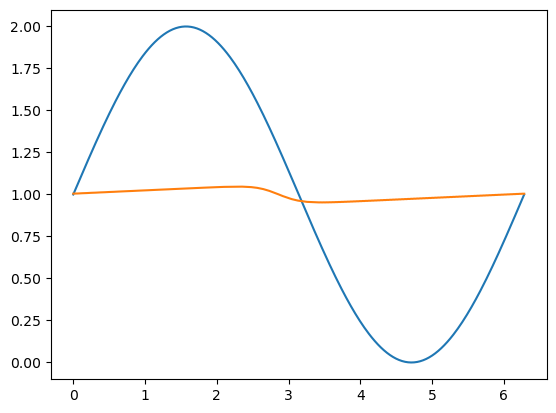

In [59]:
class BurgersEquationSpatialDiscretization:

    def __init__(self, x, t, u0, nu=1e-2):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]

    def _derivative(self, u):
        du = u.copy()
        # central finite difference
        du[1:-1] = (u[2:] - u[:-2]) / (2 * self.dx)

        ## Periodic boundary conditions
        du[0] = (u[1] - u[-1]) / self.dx
        du[-1] = (u[0] - u[-2]) / self.dx

        ## Enforce reflection boundary conditions
        # du[0] = du[1]
        # du[-1] = du[-2]

        ## Enforce Dirichlet boundary conditions
        # du[0] = 0
        # du[-1] = 0

        return du

    def _laplacian(self, u):
        ddu = u.copy()
        ddu[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / self.dx**2

        ## Periodic boundary conditions with differences
        ddu[0] = (u[1] - 2 * u[0] + u[-1]) / self.dx**2
        ddu[-1] = (u[0] - 2 * u[-1] + u[-2]) / self.dx**2

        # ## Enforce reflection boundary conditions
        # ddu[0] = ddu[1]
        # ddu[-1] = ddu[-2]


        ## Enforce Dirichlet boundary conditions
        # du[0] = 0
        # du[-1] = 0

        return ddu

    def cfl(self, c=0.5):
        """Compute the Courant-Friedrichs-Lewy number for the current time step."""
        return c * self.dt / self.dx
        # return c * self.dx / np.max(np.abs(self.u0))

    def rhs(self, t, u):
        return self.nu * self._laplacian(u) - u * self._derivative(u)

    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)



x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 200)
u0 = 1 + np.sin(x)

eq = BurgersEquationSpatialDiscretization(x, t, u0)

from scipy.integrate import solve_ivp
sol = solve_ivp(eq, (t[0], t[-1]), u0, t_eval=t)

plt.plot(x, sol.y[:, 0])
plt.plot(x, sol.y[:, -1])
plt.show()


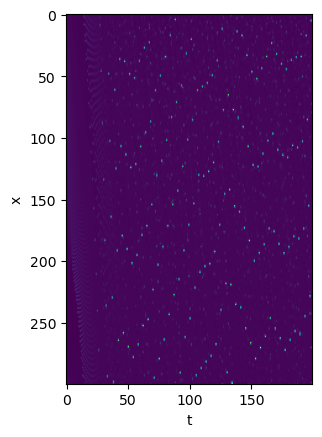

In [58]:
plt.imshow(sol.y)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

### Boundary conditions

+ Explore how changing the boundary conditions in the above code (by commenting out the lines that set the boundary conditions) changes the solution properties
+ How does the diffusivity parameter affect the dynamics?

#### Types of boundary conditions

+ Dirichlet boundary conditions: the solution is specified at the boundary
+ Neumann boundary conditions: the derivative of the solution is specified at the boundary
+ Periodic boundary conditions: the solution is periodic in space
+ Mixed boundary conditions: a combination of the above



### Some specificities of Burgers equation

+ Shock waves are discontinuities in the velocity, but not in the density
+ The shock wave is a discontinuity in the derivative of the velocity
+ Propagate ballistically, i.e. at a constant speed of sound in the fluid


### Transformation onto a linear equation

+ Burgers equation is a nonlinear PDE, but it can be transformed into a linear PDE by introducing a new variable

The Cole-Hopf transformation implies that we can substitute the variable $u(x)$ with $\phi(x)$ using the following defintion
$$
u=-2\nu {\frac {1}{\phi }}{\frac {\partial \phi }{\partial x}}
$$

Inserting this into the viscous Burgers equation gives
$$
{\frac {\partial }{\partial x}}\left({\frac {1}{\phi }}{\frac {\partial \phi }{\partial t}}\right)=\nu {\frac {\partial }{\partial x}}\left({\frac {1}{\phi }}{\frac {\partial ^{2}\phi }{\partial x^{2}}}\right)
$$
After some algebraic manipulation, we get
$$
{\frac {\partial \phi }{\partial t}}=\nu {\frac {\partial ^{2}\phi }{\partial x^{2}}}
$$
This is a linear diffusion equation, which we've already seen many methods of solving. We can solve this simplified heat equation, and then cast back into the original variables by performing the inverse transformation
$$
u(x,t)=-2\nu {\frac {\partial }{\partial x}}\ln \left\{(4\pi \nu t)^{-1/2}\int _{-\infty }^{\infty }\exp \left[-{\frac {(x-x')^{2}}{4\nu t}}-{\frac {1}{2\nu }}\int _{0}^{x'}f(x'')dx''\right]dx'\right\}.
$$


#### Takeaway: unlike our chaotic systems, the complexity of the dynamics of the Burgers equation is not intrinsic, but rather due to our choice of dynamical variables

+ In machine learning, is a problem intrinsically hard, or do we just need to pick the right coordinates?

### The Kuramoto-Sivashinsky equation

+ A nonlinear PDE that is a generalization of the Burgers equation that describes the dynamics of flame fronts
+ The solution of the Kuramoto-Sivashinsky equation is a soliton, which is a localized wave packet that moves at a constant speed

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} + \frac{\partial^4 u}{\partial x^4}$$

We can convert this equation into the frequency domain by performing a Fourier transform, and then we can solve the resulting equation in the frequency domain. The solution is a soliton, which is a localized wave packet that moves at a constant speed.

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} + \frac{\partial^4 u}{\partial x^4}$$


In [ ]:
# Solve the KuramotoSivashinsky equation with spectral methods

from scipy.integrate import solve_ivp

class KuramotoSivashinskyEquationSpectral:

    def __init__(self, x, t, u0, nu=1.0):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

    def rhs(self, t, u):
        u = u.reshape((len(self.x), 1))
        du = np.fft.fft(u, axis=0)
        ddu = np.fft.fft(du, axis=0)
        return -self.nu * du + ddu

    def solve(self):
        u0 = np.fft.fft(self.u0)
        sol = solve_ivp(self.rhs, (self.t[0], self.t[-1]), u0, t_eval=self.t)
        return np.real(np.fft.ifft(sol.y, axis=0))


In [61]:
# https://scicomp.stackexchange.com/questions/37336/solving-numerically-the-1d-kuramoto-sivashinsky-equation-using-spectral-methods
class KuramotoSivashinskySpectral:

    def __init__(self, x, t, u0, nu=1.0):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]
        self.dt = t[1] - t[0]

        self.k = np.fft.fftfreq(len(x), d=self.dx)
        self.k2 = self.k**2
        self.k4 = self.k**4

    def rhs(self, t, u):
        u = u.reshape((len(self.x), 1))
        du = np.fft.fft(u, axis=0)
        ddu = np.fft.fft(du, axis=0)
        return -self.nu * du + ddu

    def solve(self):
        u0 = np.fft.fft(self.u0)
        sol = solve_ivp(self.rhs, (self.t[0], self.t[-1]), u0, t_eval=self.t)
        return np.real(np.fft.ifft(sol.y, axis=0))


x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 200)
u0 = 1 + np.sin(x)

eq = KuramotoSivashinskySpectral(x, t, u0)
sol = eq.solve()

plt.plot(x, sol[:, 0])
plt.plot(x, sol[:, -1])
plt.show()


ValueError: cannot reshape array of size 90000 into shape (300,1)

In [ ]:
class WaveEquation:

    def __init__(self, x, t, c, dx, dt):
        self.x = x
        self.t = t
        self.c = c
        self.dx = dx
        self.dt = dt
        self.dt2 = dt ** 2
        self.dx2 = dx ** 2
        self.nx = len(x)
        self.nt = len(t)
        self.u = np.zeros((self.nx, self.nt))
        self.u[0, :] = 0
        self.u[-1, :] = 0
        self.u[:, 0] = 0
        self.u[:, 1] = 0
        self.u[:, 2] = 0

    def solve(self):
        for i in range(2, self.nt - 1):
            for j in range(1, self.nx - 1):
                self.u[j, i + 1] = 2 * self.u[j, i] - self.u[j, i - 1] + \
                    self.c ** 2 * self.dt2 / self.dx2 * (self.u[j + 1, i] - 2 * self.u[j, i] + self.u[j - 1, i])



## Galerkin methods

+ Galerkin methods are a way to solve PDEs by projecting the PDE onto a basis of functions
+ The projection is done by solving a set of ODEs, which are the equations that the basis functions satisfy
+ The solution to the PDE is then the amplitudes of the basis functions
+ The ODEs are usually solved using a numerical method, such as Runge-Kutta
+ The basis functions are usually chosen to be orthogonal, so that the amplitudes are the coefficients of the expansion of the solution in the basis

In [ ]:
class GalerkinWaveEquation:

    def __init__(self, x, t, c, dx, dt):
        self.x = x
        self.t = t
        self.c = c
        self.dx = dx
        self.dt = dt
        self.dt2 = dt ** 2
        self.dx2 = dx ** 2
        self.nx = len(x)
        self.nt = len(t)
        self.u = np.zeros((self.nx, self.nt))
        self.u[0, :] = 0
        self.u[-1, :] = 0
        self.u[:, 0] = 0
        self.u[:, 1] = 0
        self.u[:, 2] = 0

    def solve(self):
        for i in range(2, self.nt - 1):
            for j in range(1, self.nx - 1):
                self.u[j, i + 1] = 2 * self.u[j, i] - self.u[j, i - 1] + \
                    self.c ** 2 * self.dt2 / self.dx2 * (self.u[j + 1, i] - 2 * self.u[j, i] + self.u[j - 1, i])


def plot_wave_equation(x, t, u):
    plt.figure(figsize=(10, 10))
    plt.imshow(u, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.colorbar()
    plt.show()


def plot_galerkin_wave_equation(x, t, u):
    plt.figure(figsize=(10, 10))
    plt.imshow(u, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.colorbar()
    plt.show()


def plot_galerkin_wave_equation(x, t, u):

# Dedalus

+ Dedalus is a Python package for solving PDEs using spectral methods
+ Very recently published ([Burns et al Phys Rev Research 2019](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.023068))

+ Idea: specify our PDE in a high-level symbolic language, and then Dedalus will automatically generate optimized code to solve it

+ Hardware configuration and dependencies

+ Other "high-level" PDE solvers exist, especially for finite-element methods (Ansys, COMSOL, etc), but Dedalus is high quality, actively maintained (difficult to find in academic software), and completely open-source

In [ ]:
from dedalus import public as de
import numpy as np
import matplotlib.pyplot as plt

de.logging_setup.rootlogger.setLevel('ERROR')
%matplotlib inline


# Create basis and domain
# x_basis = de.Chebyshev('x', 1024, interval=(-2, 6), dealias=3/2)
x_basis = de.Fourier('x', 1024, interval=(-50, 50), dealias=1)
domain = de.Domain([x_basis], np.float64)

# Create problem, and specify field variables and derivatives
problem = de.IVP(domain, variables=['u', 'ux', 'uxx', 'uxxx'])

problem.meta[:]['x']['dirichlet'] = True


problem.parameters['a'] = 2e-4
problem.parameters['b'] = 1e-4


# Main equation, with linear terms on the LHS and nonlinear terms on the RHS
# problem.add_equation("dt(u) - a*dx(ux) - b*dx(uxx) = -u*ux")
# problem.add_equation("dt(u) + dx(uxxx) + uxx = -0.5*ux**2")
problem.add_equation("dt(u) + dx(uxxx) + uxx = -u*ux")
# Auxiliary equations defining the first-order reduction
problem.add_equation("ux - dx(u) = 0")
problem.add_equation("uxx - dx(ux) = 0")
problem.add_equation("uxxx - dx(uxx) = 0")
# problem.add_equation("uxxxx - dx(dx(uxx)) = 0")
# Boundary conditions
# problem.add_bc('left(u) = 0')
# problem.add_bc('left(ux) = 0')
# problem.add_bc('right(ux) = 0')

## Define ODE solver
solver = problem.build_solver(de.timesteppers.RK443)


# Reference local grid and state fields
x = domain.grid(0)
u = solver.state['u']
ux = solver.state['ux']
uxx = solver.state['uxx']
uxxx = solver.state['uxxx']

# Setup smooth triangle with support in (-1, 1)
# n = 20
# u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*x)**2) / (2*n)

ic = gaussian_filter1d(np.random.random(x.shape), 10)
dx_val = (2*np.pi)/len(u['g'])
u['g'] = ic/(np.sum(ic)*dx_val)

u.differentiate('x', out=ux)
ux.differentiate('x', out=uxx)
uxx.differentiate('x', out=uxxx)


# Stop stopping criteria
solver.stop_sim_time = np.inf
solver.stop_wall_time = np.inf
solver.stop_iteration = 3000




In [ ]:

# Set up storage
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]

# Main loop
dt = 1e-1
start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 5 == 0:
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)
    if solver.iteration % 100 == 0:
        print('Completed iteration {}'.format(solver.iteration))
end_time = time.time()
print('Runtime:', end_time-start_time)

In [ ]:

# Convert storage to arrays
u_array = np.array(u_list)
t_array = np.array(t_list)

# Build space and time meshes
x_da = domain.grid(0, scales=domain.dealias)
xmesh, ymesh = plot_tools.quad_mesh(x=x_da, y=t_array)

# Plot
plt.figure(figsize=(12, 8))
plt.pcolormesh(xmesh, ymesh, u_array, cmap='RdBu_r')
plt.axis(plot_tools.pad_limits(xmesh, ymesh))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')